In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv("/content/Electric_Production.csv",index_col='DATE', parse_dates=True)
df.columns = ["Production"]
df.head()


,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


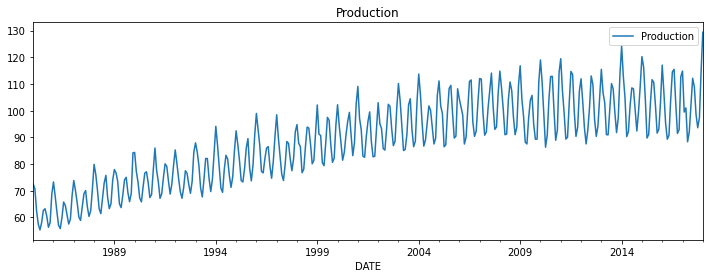

In [3]:
df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Production')
plt.show(block=False)

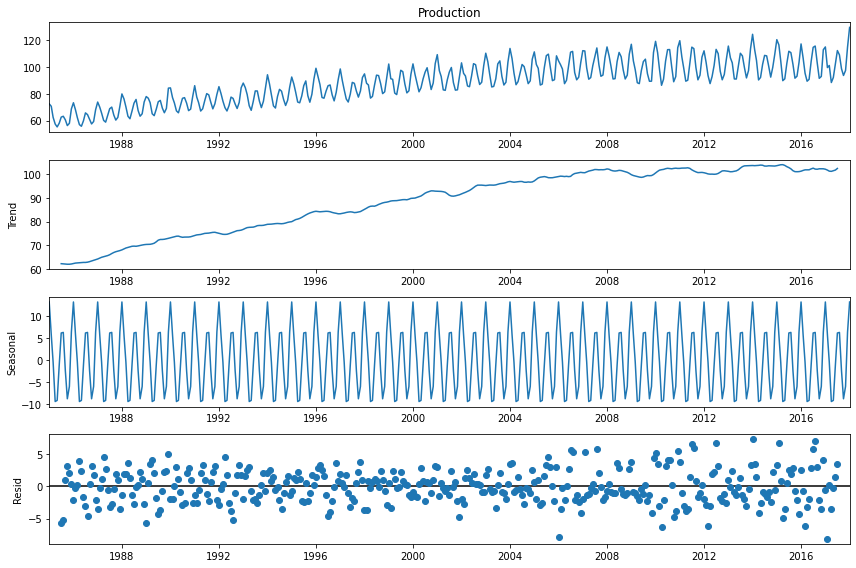

In [4]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df.Production)
fig = decomposition.plot()
plt.show()


Data Preparation

In [5]:
train_len = 360
train=df[0:train_len]
test=df[train_len:] 
print("Training set: ", train.shape)
print("Testing set: ", test.shape)

Training set:  (360, 1)
Testing set:  (37, 1)


In [6]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [7]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
n_months = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

In [9]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(n_months, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(generator, epochs=10)

Epoch 1/10
348/348 [==============================] - 4s 7ms/step - loss: 0.0236
Epoch 2/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0151
Epoch 3/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0134
Epoch 4/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0097
Epoch 5/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0060
Epoch 6/10
348/348 [==============================] - 3s 7ms/step - loss: 0.0058
Epoch 7/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0037
Epoch 8/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0030
Epoch 9/10
348/348 [==============================] - 3s 7ms/step - loss: 0.0026
Epoch 10/10
348/348 [==============================] - 3s 7ms/step - loss: 0.0024


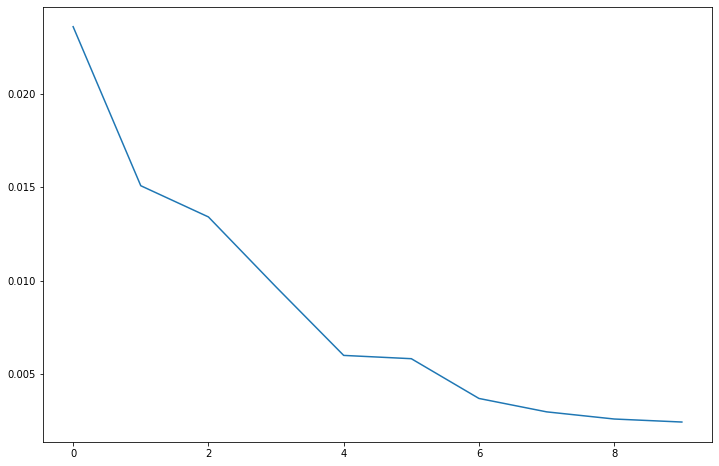

In [11]:
plt.plot(history.history['loss'])
plt.show()

In [12]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

1/1 [==============================] - 0s 251ms/step


array([[0.8991796]], dtype=float32)

In [13]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)



1/1 [==============================] - 0s 18ms/step


In [14]:
test['LSTM_Predictions'] = scaler.inverse_transform(test_predictions)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


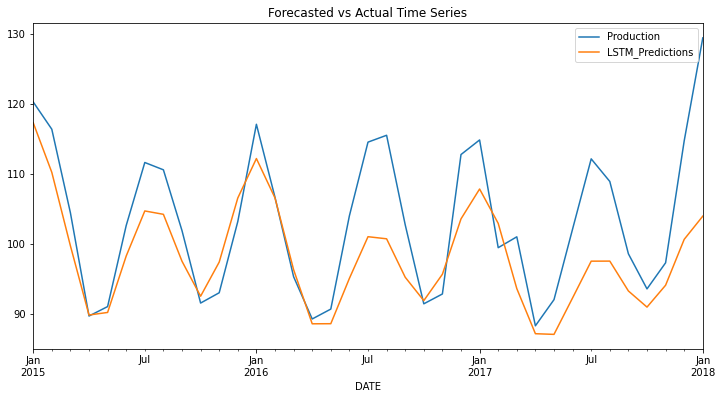

In [15]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()

In [16]:
test.head(10)

,Production,LSTM_Predictions
DATE,,
2015-01-01,120.2696,117.304360
2015-02-01,116.3788,110.232063
2015-03-01,104.4706,99.760942
2015-04-01,89.7461,89.890921
2015-05-01,91.0930,90.256605
2015-06-01,102.6495,98.299615
2015-07-01,111.6354,104.727050
2015-08-01,110.5925,104.247124
2015-09-01,101.9204,97.556524
